In [23]:
import numpy as np
import pandas as pd

from power.ml_ops.data import clean_pv_data, get_pv_data
from power.params import *
from pathlib import Path

from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, optimizers
from power.ml_ops.data import get_data_with_cache, load_data_to_bq, clean_pv_data
from power.ml_ops.registry import load_model, save_model, save_results
import tensorflow as tf

import matplotlib.pyplot as plt

In [35]:
pv_raw_data = get_pv_data()
pv_df = clean_pv_data(pv_raw_data)
pv_df.rename(columns={'electricity': 'power'}, inplace=True)
pv_df.head(3)

# data loaded
# data cleaned


,utc_time,local_time,power
0,1980-01-01 00:00:00+00:00,1980-01-01 01:00:00+01:00,0.0
1,1980-01-01 01:00:00+00:00,1980-01-01 02:00:00+01:00,0.0
2,1980-01-01 02:00:00+00:00,1980-01-01 03:00:00+01:00,0.0


In [36]:
train = pv_df[pv_df['utc_time'] < '2020-01-01']
test = pv_df[pv_df['utc_time'] >= '2020-01-01']

In [37]:
print(len(train))
print(len(test))

350640
26304


In [38]:
train = train[['power']]
test = test[['power']]

In [39]:
def get_Xi_yi(
    fold:pd.DataFrame,
    input_length:int,       # 48
    output_length:int,      # 24
    gap_hours):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    - TARGET is the variable(s) we want to predict (name of the column(s))
    '''
    TARGET = 'power'
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + gap_hours + output_length) + 1

    random_start = np.random.randint(first_possible_start, last_possible_start)

    input_start = random_start
    input_end = random_start + input_length
    target_start = input_end + gap_hours
    target_end = target_start + output_length

    X_i = fold.iloc[input_start:input_end]
    y_i = fold.iloc[target_start:target_end][[TARGET]]    # creates a pd.DataFrame for the target y

    return (X_i, y_i)

def get_X_y_seq(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int,
    gap_hours=0):
    '''
    Given a fold, it creates a series of sequences randomly
    as many as being specified
    '''

    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length, gap_hours)   # calls the previous function to generate sequences X + y
        X.append(Xi)
        y.append(yi)

    return np.array(X), np.array(y)


In [40]:
X_train, y_train = get_X_y_seq(train, number_of_sequences=10_000, input_length=48, output_length=24)

In [41]:
X_test, y_test = get_X_y_seq(test, number_of_sequences=1_000, input_length=48, output_length=24)

In [42]:
X_train.shape, y_train.shape

((10000, 48, 1), (10000, 24, 1))

In [43]:
X_test.shape, y_test.shape

((1000, 48, 1), (1000, 24, 1))

In [44]:
def init_model(X_train, y_train, n_unit=24, learning_rate=0.02):


    # 1 - RNN architecture
    # ======================
    model = models.Sequential()

    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(n_unit,
                          activation='tanh',
                          return_sequences = False,
                          input_shape=(X_train.shape[1],X_train.shape[2])
                          ))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================

    def r_squared(y_true, y_pred):
        ss_res = K.sum(K.square(y_true - y_pred))
        ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
        return (1 - ss_res/(ss_tot + K.epsilon()))

    adam = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=adam, metrics=['mae', r_squared])

    return model

In [45]:
model = init_model(X_train, y_train)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24)                2496      
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
Total params: 3,096
Trainable params: 3,096
Non-trainable params: 0
_________________________________________________________________


2024-03-08 17:39:48.313059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-08 17:39:48.320115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-08 17:39:48.324657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [46]:
es = EarlyStopping(monitor = "val_mae",
                   mode = "min",
                   patience = 5,
                   restore_best_weights = True)
history = model.fit(X_train, y_train,
                    validation_split = 0.3,
                    shuffle = False,
                    batch_size = 32,
                    epochs = 50,
                    callbacks = [es],
                    verbose = 0)

2024-03-08 17:39:52.429953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-08 17:39:52.437921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-08 17:39:52.442118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

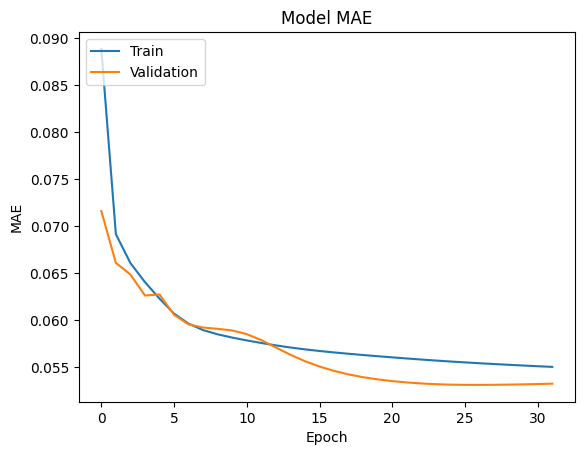

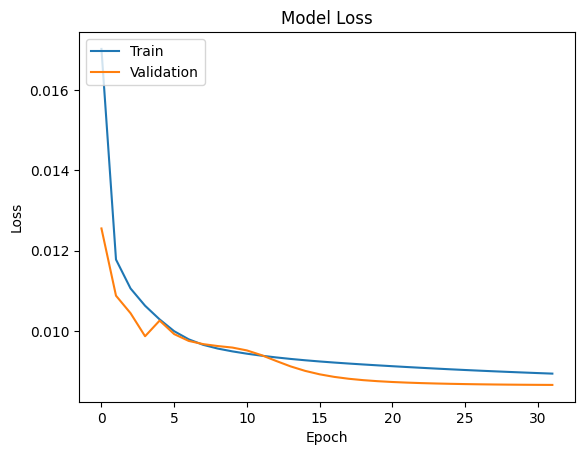

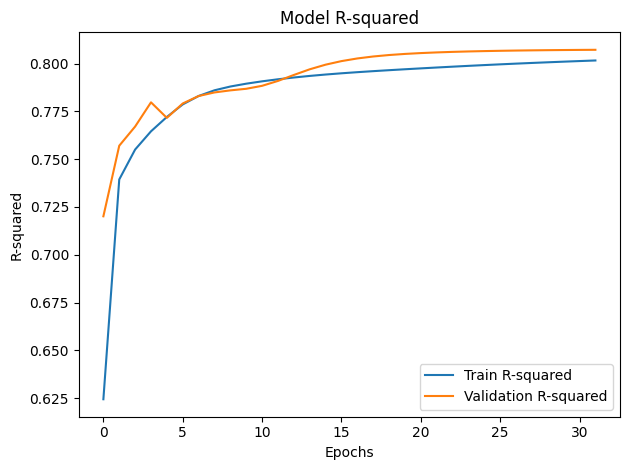

In [47]:
# Plot training & validation MAE values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting R-squared for Train and Validation
#plt.subplot(1, 2, 2)
plt.plot(history.history['r_squared'], label='Train R-squared')
plt.plot(history.history['val_r_squared'], label='Validation R-squared')
plt.title('Model R-squared')
plt.xlabel('Epochs')
plt.ylabel('R-squared')
plt.legend()

plt.tight_layout()
plt.show()

In [104]:
res = model.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} kW")

32/32 [==============================] - 0s 6ms/step - loss: 0.0104 - mae: 0.0594 - r_squared: 0.7811
The LSTM MAE on the test set is equal to 0.06 kW


In [56]:
pred_example = tf.convert_to_tensor(X_test[500])

In [59]:
pred_example_ready = tf.expand_dims(pred_example, axis=0)

In [61]:
pred_example_ready.shape

TensorShape([1, 48, 1])

In [48]:
query = f"""
    SELECT *
    FROM {GCP_PROJECT}.{BQ_DATASET}.raw_pv
    ORDER BY _0
"""

data_query_cache_path = Path(LOCAL_DATA_PATH).joinpath("raw", f"raw_pv.csv")
data_query = get_data_with_cache(
    query=query,
    gcp_project=GCP_PROJECT,
    cache_path=data_query_cache_path,
    data_has_header=True
)

# Process data
data_clean = clean_pv_data(data_query)


Load data from local CSV...
✅ Data loaded, with shape (376944, 8)
# data cleaned


In [21]:
def extract_pv_data(input_date: str, n_days=10):
    pv_data_clean = data_clean
    input_timestamp = pd.Timestamp(input_date, tz='UTC')
    idx = pv_data_clean[pv_data_clean.utc_time == input_timestamp].index[0]

    n_rows = 24 * n_days
    if idx <= n_rows:
        df = pv_data_clean.iloc[0:idx+24,:]
    else:
        df = pv_data_clean.iloc[idx-n_rows:idx+24,:].reset_index()
    extracted_data = {
        'utc_time':df.get('utc_time').tolist(),
        'local_time':df.get('local_time').tolist(),
        'electricity':df.get('electricity').tolist()
    }
    return extracted_data

In [22]:
df = pd.DataFrame(extract_pv_data('2013-05-08 09:00:00', 1))

In [26]:
df= df.rename(columns={'electricity': 'power'})

In [27]:
df = df[['power']]

In [62]:
prediction = model.predict(pred_example_ready)

2024-03-08 18:00:07.246330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-08 18:00:07.280921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-08 18:00:07.299790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 3s 3s/step


In [63]:
prediction

array([[ 0.01071889,  0.02131082,  0.06256487,  0.1574947 ,  0.27723542,
         0.38149548,  0.45364466,  0.46665573,  0.41728395,  0.3141311 ,
         0.18846399,  0.07135911, -0.0074121 , -0.03423558, -0.02154276,
        -0.00171639, -0.00088419, -0.00294772, -0.00823241, -0.00279473,
         0.00450245,  0.00884393,  0.01748355,  0.00699423]],
      dtype=float32)

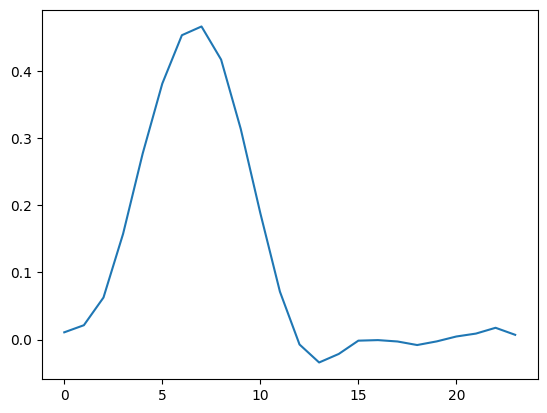

In [65]:
plt.plot(prediction[0])

In [5]:
from power.params import *

input_pred = '2013-05-08 12:00:00'

query = f"""
    SELECT *
    FROM {GCP_PROJECT}.{BQ_DATASET}.processed_pv
    ORDER BY utc_time
"""

data_processed_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
data_processed = get_data_with_cache(
    gcp_project=GCP_PROJECT,
    query=query,
    cache_path=data_processed_cache_path,
    data_has_header=True
)

X_pred = data_processed[data_processed['utc_time'] < input_pred][-48:]



Load data from local CSV...
✅ Data loaded, with shape (376944, 3)


In [7]:
X_pred

,utc_time,local_time,electricity
292308,2013-05-06 12:00:00+00:00,2013-05-06 12:00:00+00:00,0.641
292309,2013-05-06 13:00:00+00:00,2013-05-06 13:00:00+00:00,0.517
292310,2013-05-06 14:00:00+00:00,2013-05-06 14:00:00+00:00,0.381
292311,2013-05-06 15:00:00+00:00,2013-05-06 15:00:00+00:00,0.235
292312,2013-05-06 16:00:00+00:00,2013-05-06 16:00:00+00:00,0.117
292313,2013-05-06 17:00:00+00:00,2013-05-06 17:00:00+00:00,0.038
292314,2013-05-06 18:00:00+00:00,2013-05-06 18:00:00+00:00,0.000
292315,2013-05-06 19:00:00+00:00,2013-05-06 19:00:00+00:00,0.000
292316,2013-05-06 20:00:00+00:00,2013-05-06 20:00:00+00:00,0.000
292317,2013-05-06 21:00:00+00:00,2013-05-06 21:00:00+00:00,0.000


In [10]:
type(X_pred)

pandas.core.frame.DataFrame

In [11]:
X_pred = X_pred.rename(columns={'electricity': 'power'})

In [12]:
X_pred = X_pred[['power']]

In [13]:
X_pred.head(3)

,power
292308,0.641
292309,0.517
292310,0.381


In [16]:
X_pred = X_pred.to_numpy()

In [18]:
X_pred.shape

(48, 1)

In [19]:
X_pred_tf = tf.convert_to_tensor(X_pred)

In [20]:
X_pred_tf = tf.expand_dims(X_pred_tf, axis=0)

In [21]:
X_pred_tf.shape

TensorShape([1, 48, 1])

In [24]:
model = load_model()


Load latest model from GCS...
✅ Latest model downloaded from cloud storage


2024-03-11 10:29:22.034476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-11 10:29:22.038236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-11 10:29:22.040628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [25]:
y_pred = model.predict(X_pred_tf)

1/1 [==============================] - 0s 469ms/step


2024-03-11 10:29:26.987846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-11 10:29:26.991061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-11 10:29:26.992815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

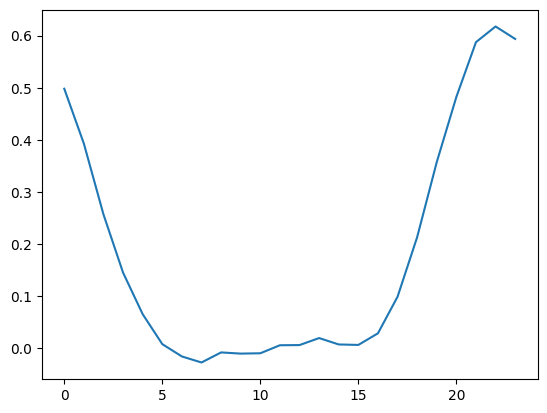

In [29]:
plt.plot(y_pred[0])

In [31]:
def pred(input_pred:str = '2013-05-08 12:00:00',
         min_date = '2020-01-01 00:00:00',
         max_date = '2022-12-29 23:00:00',) -> np.ndarray:
    """
    Make a prediction using the latest trained model
    """

    print("\n⭐️ Use case: predict")

    # X_pred = datetime.strptime(X_pred, '%Y-%m-%d %H:%M:%S')
    # reference_datetime = datetime.strptime("1980-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
    # time_difference = X_pred - reference_datetime
    # time_difference_hours = time_difference.total_seconds() / 3600
    # input_date = X_test[time_difference_hours-47: time_difference_hours+1]


    query = f"""
        SELECT *
        FROM {GCP_PROJECT}.{BQ_DATASET}.processed_pv
        ORDER BY utc_time
    """

    data_processed_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
    data_processed = get_data_with_cache(
        gcp_project=GCP_PROJECT,
        query=query,
        cache_path=data_processed_cache_path,
        data_has_header=True
    )

    X_pred = data_processed[data_processed['utc_time'] < input_pred][-48:]

    X_pred= X_pred.rename(columns={'electricity': 'power'})

    X_pred = X_pred[['power']]

    X_pred = X_pred.to_numpy()

    X_pred_tf = tf.convert_to_tensor(X_pred)

    X_pred_tf = tf.expand_dims(X_pred_tf, axis=0)


    model = load_model()
    assert model is not None

    # X_processed = preprocess_features(X_pred)
    y_pred = model.predict(X_pred_tf)

    print("\n✅ prediction done: ", y_pred, y_pred.shape, "\n")

    return y_pred

In [33]:
y_pred = pred(input_pred = '2013-05-08 12:00:00',
         min_date = '2020-01-01 00:00:00',
         max_date = '2022-12-29 23:00:00',)


⭐️ Use case: predict

Load data from local CSV...
✅ Data loaded, with shape (376944, 3)

Load latest model from GCS...


2024-03-11 10:40:37.024314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-11 10:40:37.027020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-11 10:40:37.028956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Latest model downloaded from cloud storage
1/1 [==============================] - 0s 458ms/step

✅ prediction done:  [[-0.0141912  -0.00516784 -0.01522029 -0.01000807  0.02193327  0.11062646
   0.2382429   0.38264665  0.5168554   0.6130229   0.6347649   0.5840196
   0.48178482  0.34857953  0.24210297  0.15337421  0.08134153  0.02624181
  -0.01436293 -0.03075962 -0.02758183 -0.02429959 -0.02507992 -0.01443125]] (1, 24) 



2024-03-11 10:40:37.487935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-11 10:40:37.489716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-11 10:40:37.491410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

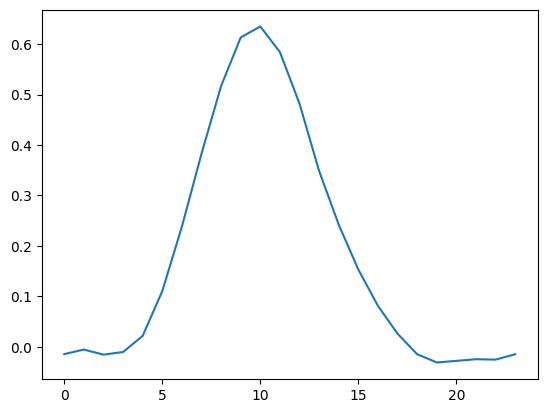

In [35]:
plt.plot(y_pred[0])